In [9]:
import sys
sys.path.append('./models/')
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from data_loader import Dataset
import models.unet_normals as unet
from tensorboardX import SummaryWriter
from PIL import Image 
# import OpenEXR, Imath
import imageio
from torchvision import transforms, utils
from matplotlib import interactive
interactive(True)


class OPT():
    def __init__(self):
        self.dataroot = './data/'
        self.file_list = './data/datalist'
        self.weights_path = './data/results/weights'
        self.batchSize = 1
        self.shuffle = False
        self.phase = 'eval'
        self.num_epochs = 500
        self.imsize = 224
        self.num_classes = int(2)
        self.gpu = '0'
        self.logs_path = 'logs/exp2'
        self.use_pretrained = True

opt = OPT()


###################### Options #############################
phase = opt.phase
device = torch.device("cuda:"+ opt.gpu if torch.cuda.is_available() else "cpu")

###################### TensorBoardX #############################
# if os.path.exists(opt.logs_path):
#     raise Exception('The folder \"{}\" already exists! Define a new log path or delete old contents.'.format(opt.logs_path))
    
writer = SummaryWriter(opt.logs_path, comment='create-graph')
graph_created = False

###################### DataLoader #############################
dataloader = Dataset(opt)


###################### ModelBuilder #############################
model = unet.Unet(num_classes=opt.num_classes)
criterion = nn.CrossEntropyLoss(reduction='sum').to(device)

# Load weights from checkpoint
if (opt.use_pretrained == True):
    checkpoint_path = 'logs/exp1/checkpoints/checkpoint-epoch_405.pth'
    model.load_state_dict(torch.load(checkpoint_path))
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



# Run evaluation of the occlusion boundary model

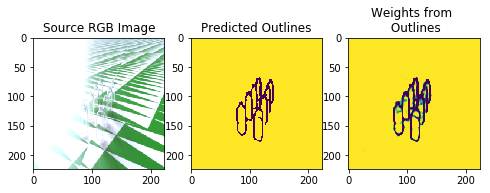

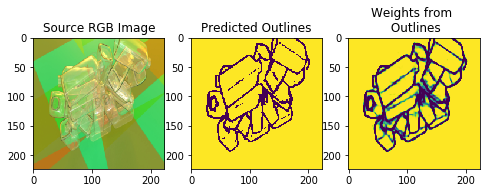

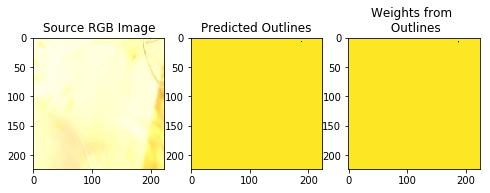

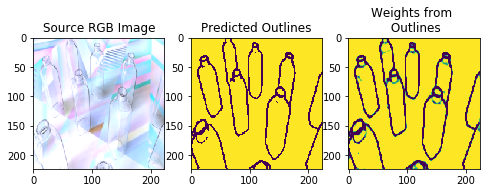

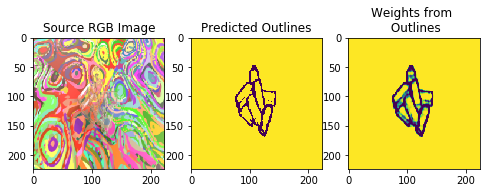

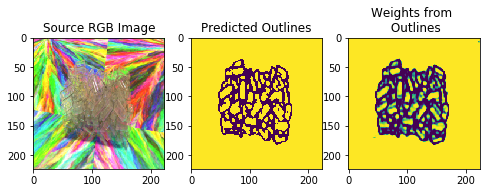

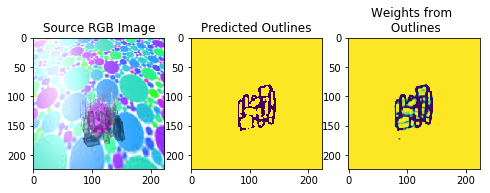

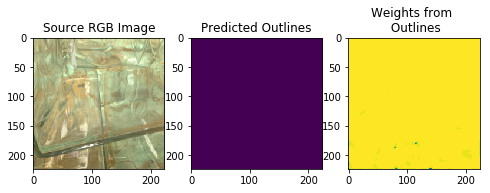

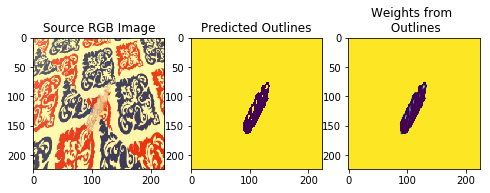

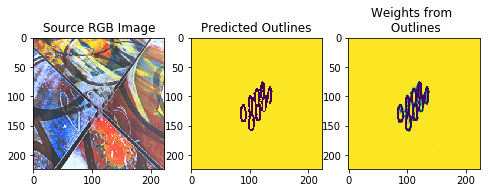

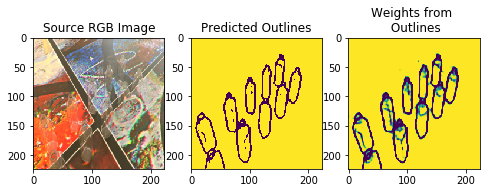

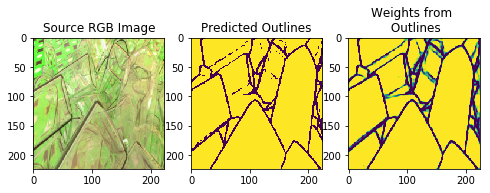

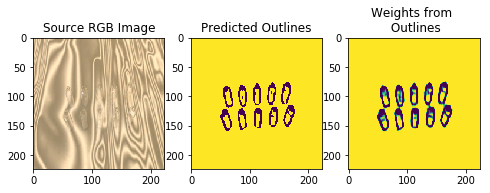

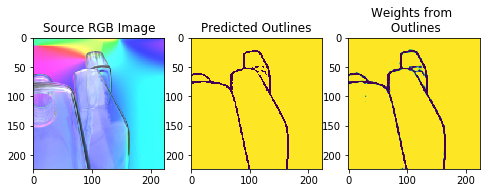

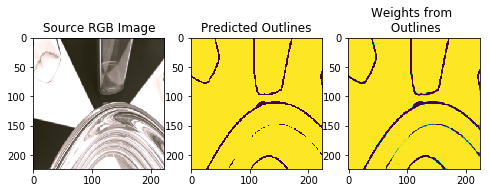

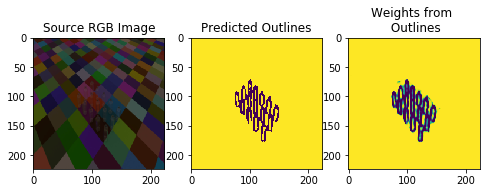

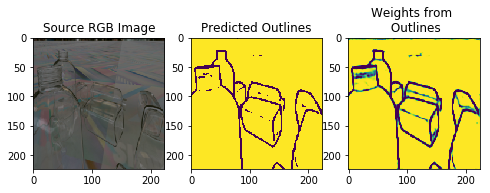

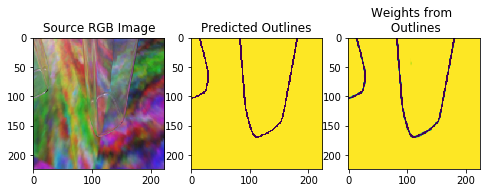

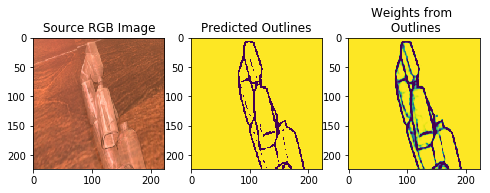

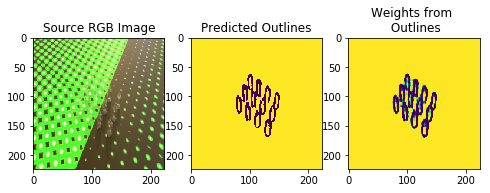

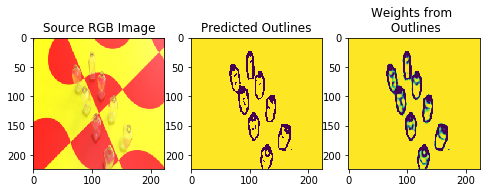

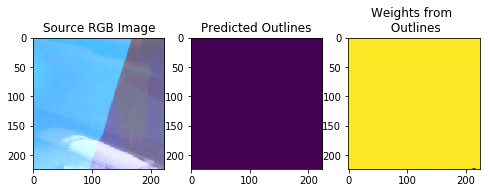

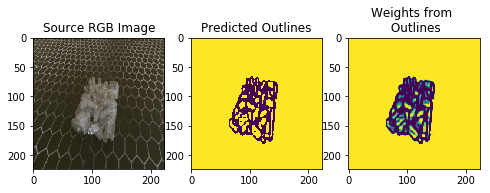

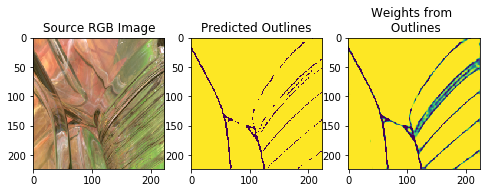

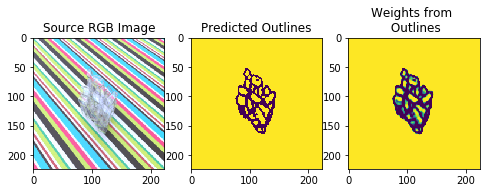

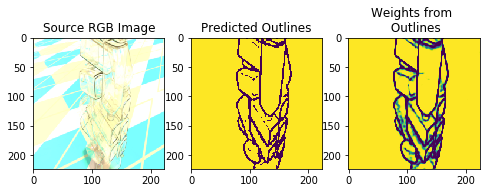

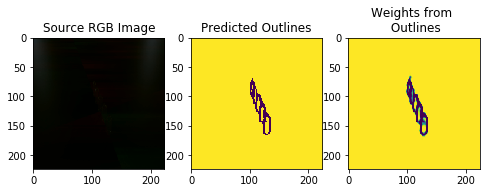

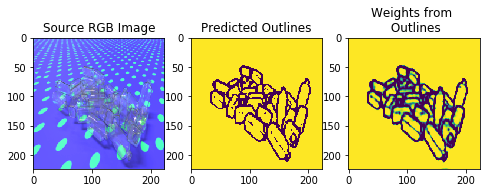

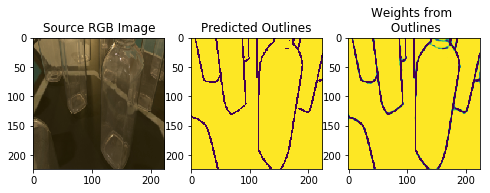

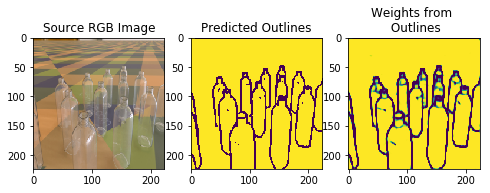

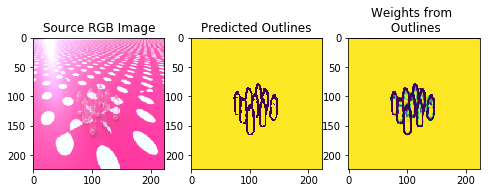

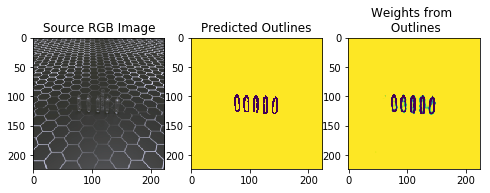

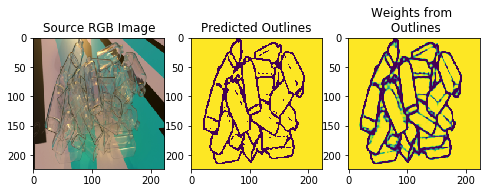

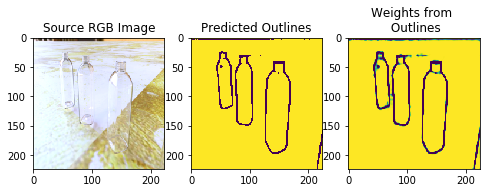

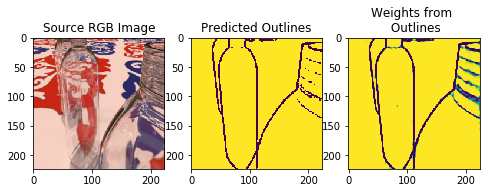

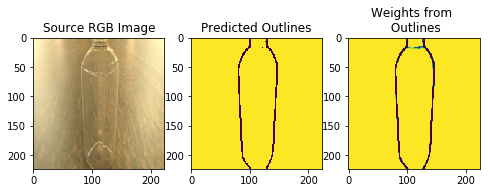

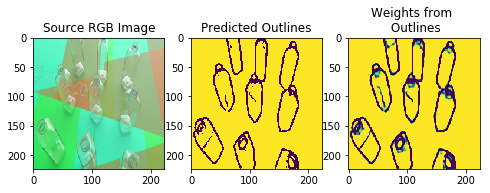

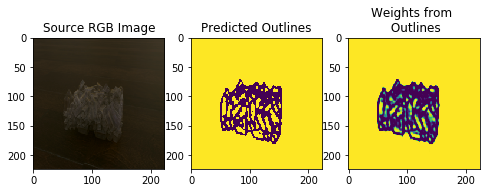

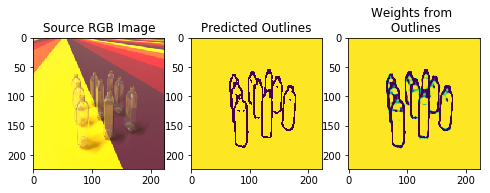

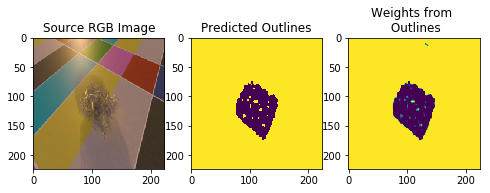

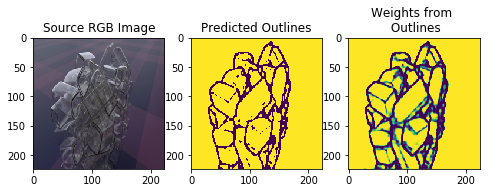

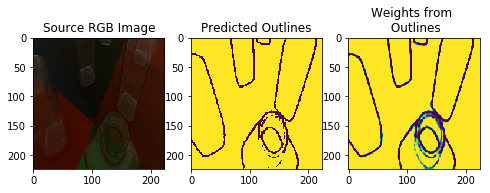

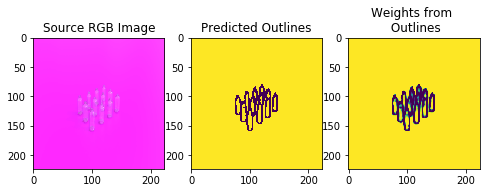

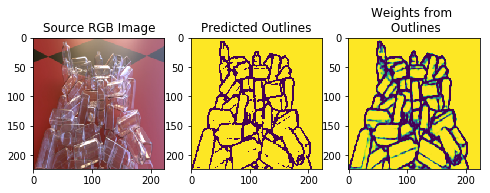

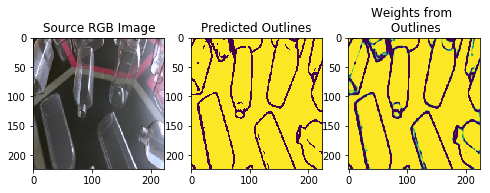

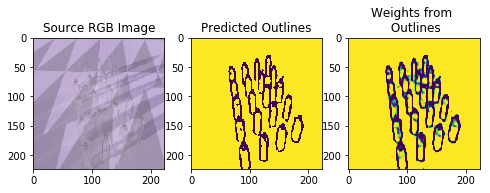

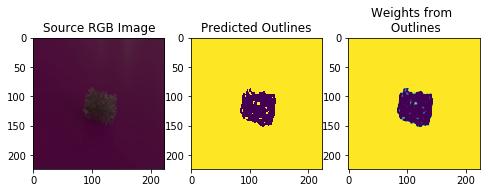

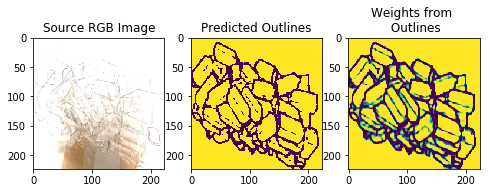

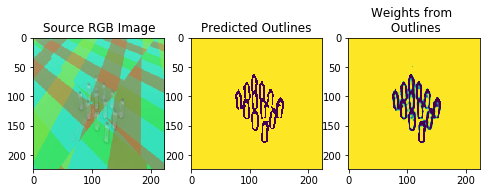

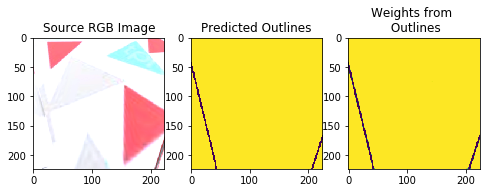

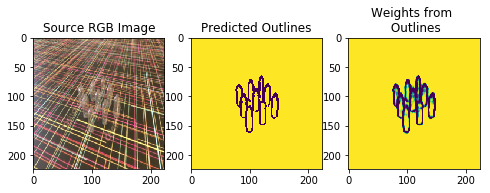

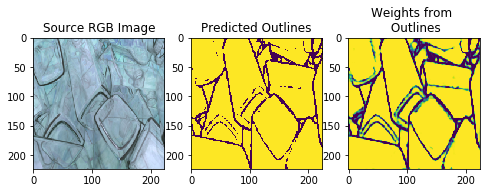

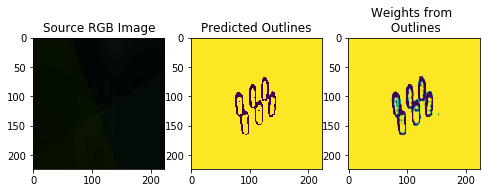

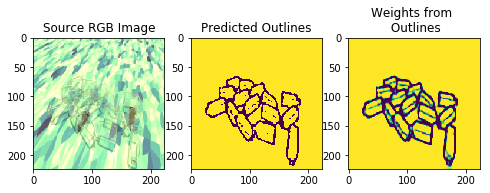

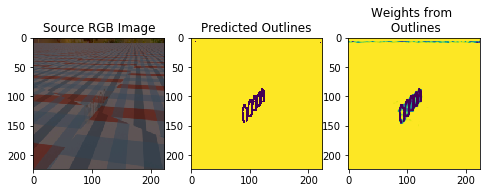

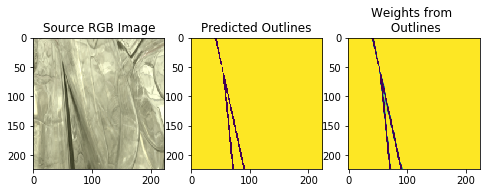

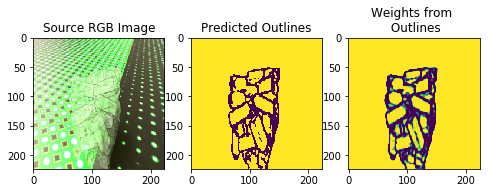

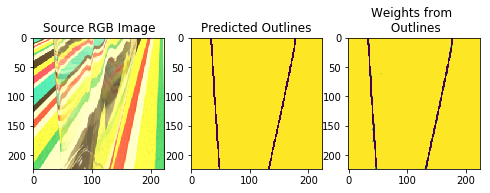

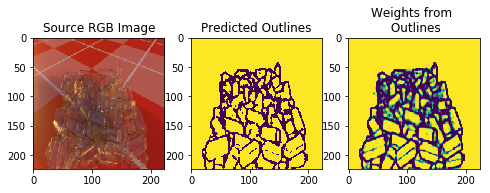

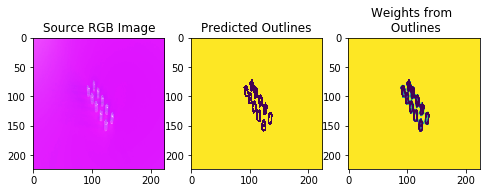

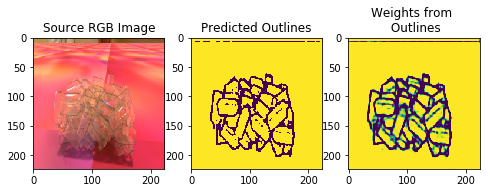

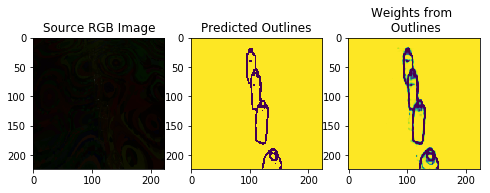

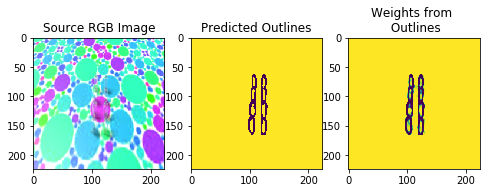

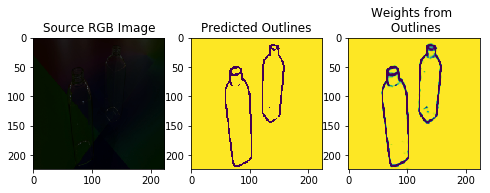

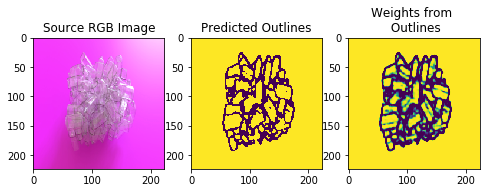

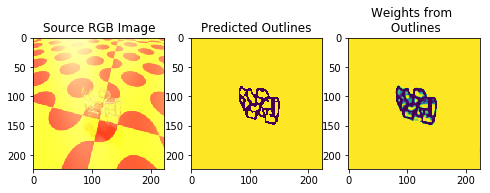

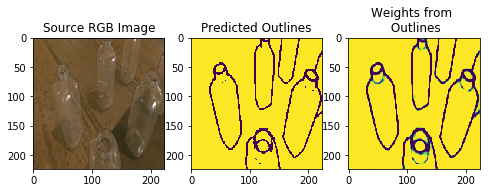

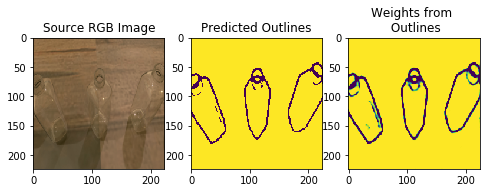

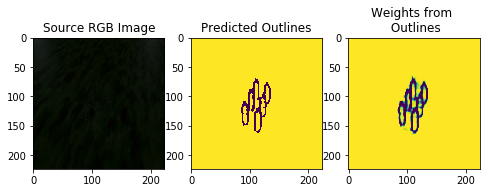

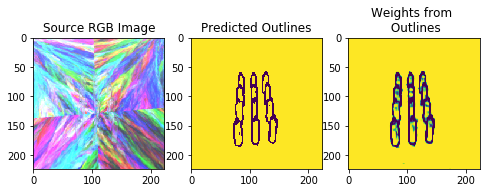

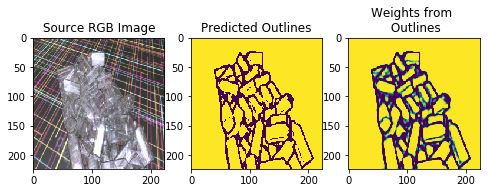

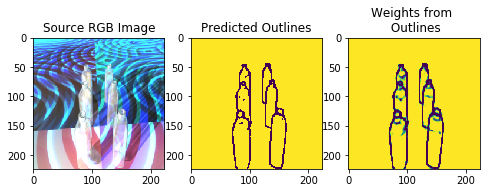

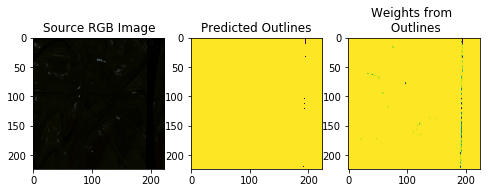

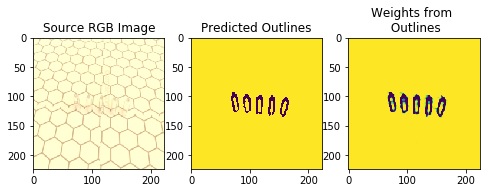

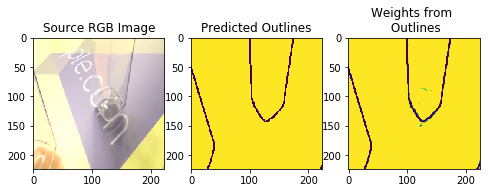

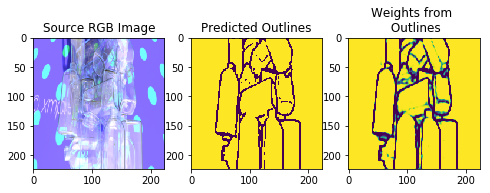

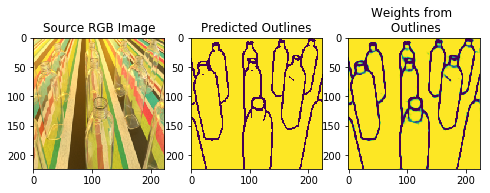

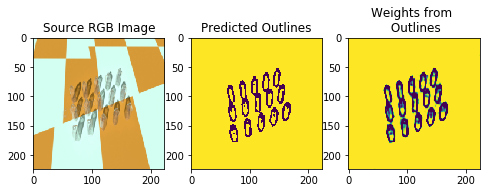

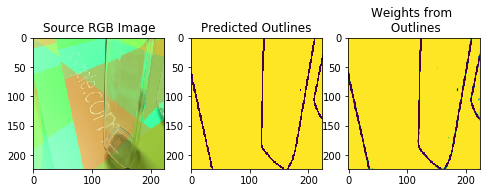

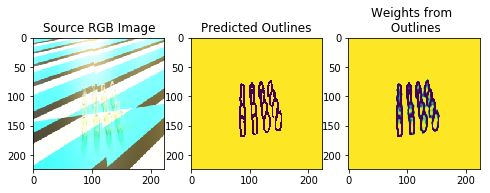

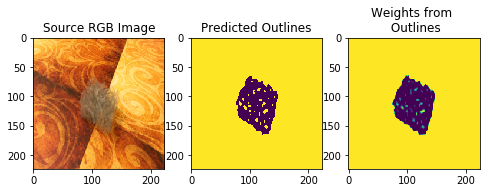

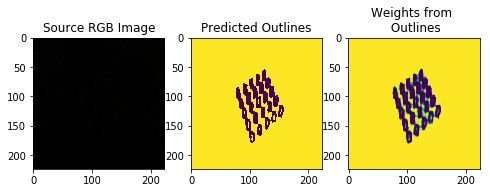

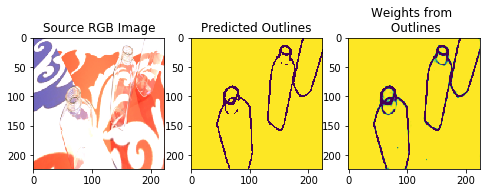

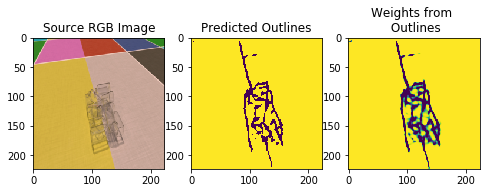

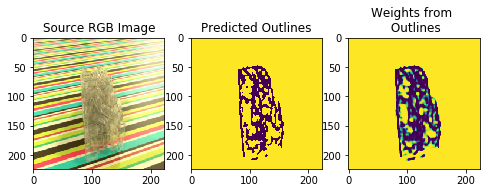

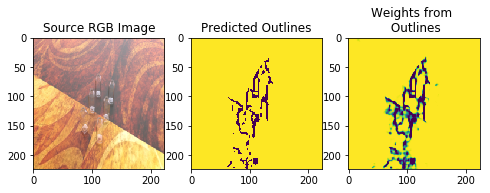

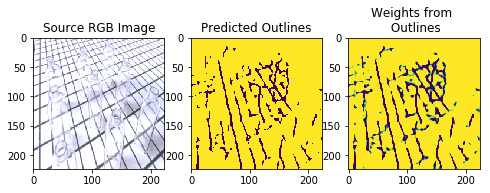

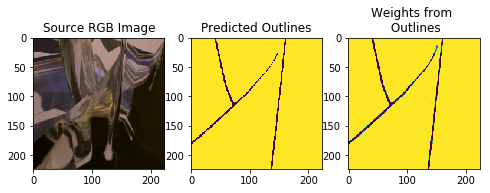

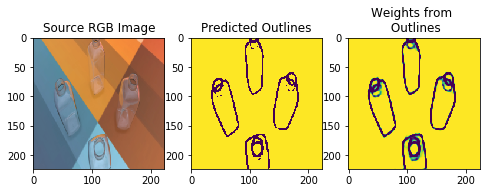

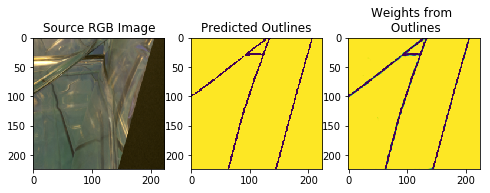

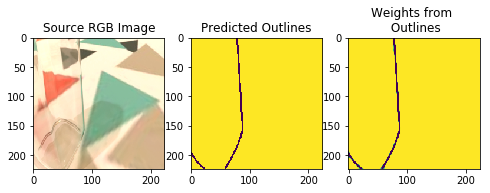

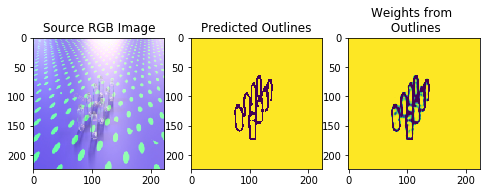

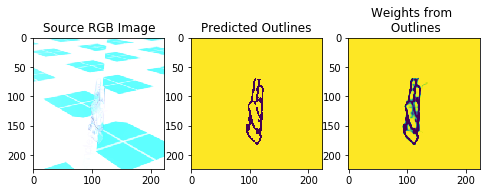

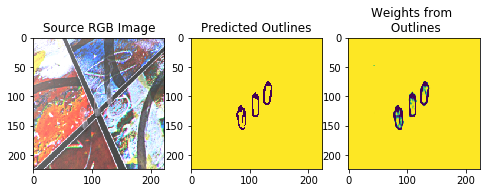

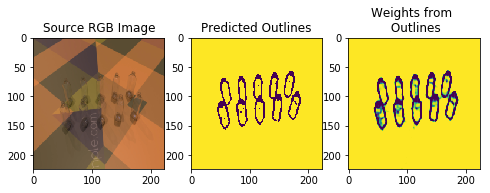

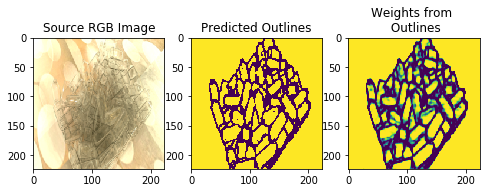

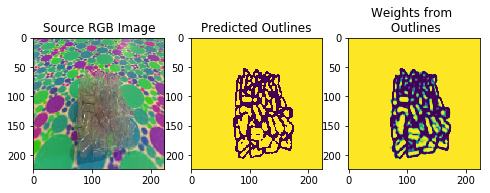

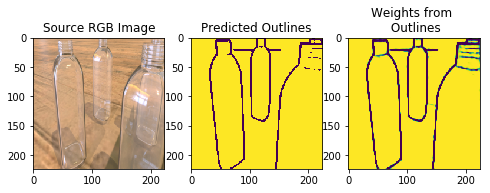

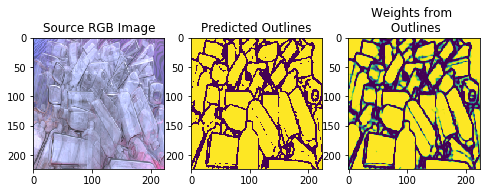

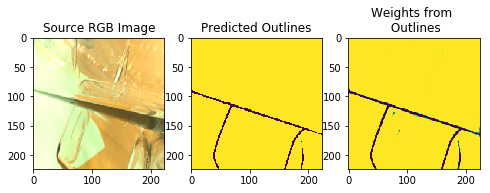

In [34]:
%matplotlib inline 
# %matplotlib qt  

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = nn.DataParallel(model)

### NOTE!!!!!!!!!!!!!!!!!!!!!!!!!
# tHE model has reversed inputs somehow! The class 0 - outlines, class 1 - background. How did this happen? make func to bring to correct order.

weights_path = './data/results/weights'
model.to(device)
  
model.eval()

for i in range(int(dataloader.size()/opt.batchSize)):
    # Get data
    inputs, labels =  dataloader.get_batch()
    
    # Forward pass of the mini-batch
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    # Forward Prop
    optimizer.zero_grad()
    torch.set_grad_enabled(True)
    logits = model(inputs)
    
    # calculating occlusion weights
    logits_softmax = nn.Softmax(dim=1)(logits).detach().cpu().numpy().astype(np.float32)
    file_arr = logits_softmax[0] # select the first img
    weight = (1-file_arr[0,:,:])
    x = np.power(weight,3)
    x = np.multiply(x,1000)
    final_weight = x.astype(np.uint16)
    
    # model predictions absolute - each pixel classified into 1 class
    predictions = torch.max(logits, 1)[1].detach().cpu().numpy()
    predictions = predictions[0]  # select the first img
    
#     # model predictions - each pixel have probability. Needs to have 3 classes to display.
#     predictions = (logits_softmax * 255).astype(np.uint8)
#     print('pred2', predictions.shape)
#     predictions = predictions[0].transpose((1,2,0)) # select the first img
#     z = np.zeros((predictions.shape[0], predictions.shape[1], 1), dtype=predictions.dtype)
#     predictions = np.concatenate((z,predictions) , axis=2)
#     print('pred', predictions.shape)
    
    #original rgb image
    rgb_img = inputs.detach().cpu()
    rgb_img = rgb_img[0] # select the first img
    inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
            std=[1/0.229, 1/0.224, 1/0.255]
        )
    rgb_img = inv_normalize(rgb_img)
    rgb_img = rgb_img.numpy()
    rgb_img = np.transpose(rgb_img, (1,2,0))
    
    fig = plt.figure(figsize=(8, 6))
    ax0 = plt.subplot(131)
    ax1 = plt.subplot(132)
    ax2 = plt.subplot(133)

    ax0.imshow(rgb_img)
    ax0.set_title('Source RGB Image')  # subplot 211 title
    ax1.imshow(predictions)
    ax1.set_title('Predicted Outlines')
    ax2.imshow(final_weight)
    ax2.set_title('Weights from \n Outlines')

    plt.show()
    
    #save weights file
    array_buffer = final_weight.tobytes()
    img = Image.new("I", final_weight.T.shape)
    img.frombytes(array_buffer, 'raw', 'I;16')
    img.save('data/results/weights_png/%09d-occlusion-weight.png' % (i))

    fig.savefig('data/results/%04d-results.png' % (i))
    plt.close('all')